# Experiments in substituting a transformer-based architecture for robot control

In [2]:
import sys
sys.path.append("..")
from settings import Config

import pathlib
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

from gen_synthetic_data import generate_training_sequence, create_training_sequence_prediction, create_training_sequence_xy

## Training data

Generating predictable and unpredictable training data.

FIXME: this is the same as in the LSTM 

Inputs shape: torch.Size([90, 10, 7])
Targets shape: torch.Size([90, 7])


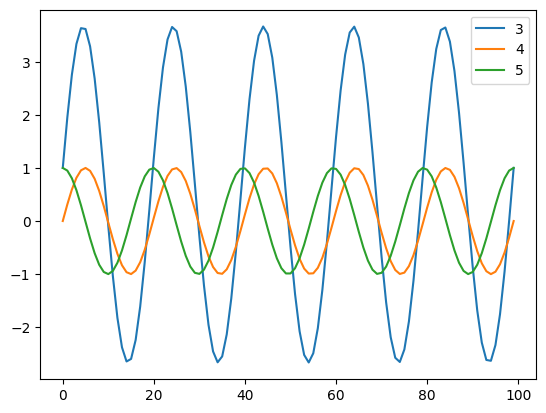

In [3]:
# Experiments in visualizing the generated training sequence
total_length = 100
# latent_size = 6
x_seq, y_seq = generate_training_sequence(total_length=100, latent_size=7)
plt.plot(y_seq[0:100,3], label= "3")
plt.plot(x_seq[0:100,4], label= "4")
plt.plot(x_seq[0:100,5], label= "5")
plt.legend()

sequence_length = 10  # Number of vectors in input sequence
inputs, targets = create_training_sequence_prediction(x_seq, sequence_length=sequence_length)
# Verify shapes
print("Inputs shape:", inputs.shape)   # Expected: [num_samples, sequence_length, latent_size]
print("Targets shape:", targets.shape) # Expected: [num_samples, latent_size]

End of code duplicated from the LSTM

In [4]:

# Hyperparameters
latent_size = 7  # Dimension of each vector in the input/output sequence
nhead = 1
# 4              # Number of attention heads in the multi-head attention
num_layers = 2         # Number of transformer encoder/decoder layers
hidden_dim = 5 # this is the y-size
#hidden_dim = 128       # Dimension of the feedforward layer within the transformer
seq_length = 10        # Sequence length (number of time steps in input/output sequences)

class TransformerSequencePredictor(nn.Module):
    def __init__(self, latent_dimension, nhead, hidden_dim, num_layers, seq_length):
        super(TransformerSequencePredictor, self).__init__()
        
        # Positional encoding (to account for sequence order)
        self.positional_encoding = nn.Parameter(torch.zeros(1, seq_length, latent_dimension))
        
        # Transformer
        self.transformer = nn.Transformer(
            d_model=latent_dimension,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=hidden_dim
        )
        
        # Output layer (maps transformer output to latent_dimension space)
        self.fc = nn.Linear(latent_dimension, latent_dimension)
    
    def forward(self, src, tgt):
        # Add positional encoding to input sequences
        src = src + self.positional_encoding[:, :src.size(1), :]
        tgt = tgt + self.positional_encoding[:, :tgt.size(1), :]
        
        # Pass through the transformer
        transformer_output = self.transformer(src, tgt)
        
        # Output layer to predict each time step's vector in the latent space
        output = self.fc(transformer_output)
        return output


In [5]:

# Example usage:
# Instantiate the model
model = TransformerSequencePredictor(latent_size, nhead, hidden_dim, num_layers, seq_length)

# Sample input and target sequences (batch size = 1, seq length = 10, latent dimension = 64)
# src = torch.randn(seq_length, 1, latent_size)  # Input sequence
# tgt = torch.randn(seq_length, 1, latent_size)  # Target sequence

# generate experimental data
src = x_seq[0:seq_length]
tgt = y_seq[0:seq_length]

src = src.unsqueeze(1)
tgt = tgt.unsqueeze(1)
print(src.shape)

# Expand the tgt because it has to be the same size, this is a hack hack hack
tgte = torch.zeros(seq_length, 1, latent_size)  # Target sequence
tgte[:tgt.size(0), :tgt.size(1), :tgt.size(2)] = tgt

tgt = tgte

# Forward pass through the model
output = model(src,tgt)
print(output.shape)  # Output shape: (seq_length, batch_size, latent_dimension)


/home/robert/anaconda3/envs/berrypicklogi/lib/python3.10/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


torch.Size([10, 1, 7])
torch.Size([10, 1, 7])


In [6]:
# Define a loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Example training loop
for epoch in range(1000):
    optimizer.zero_grad()
    
    # Forward pass
    output = model(src, tgt)
    
    # Compute loss (between predicted sequence and target sequence)
    loss = criterion(output, tgt)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


Epoch 0, Loss: 1.9727362394332886
Epoch 100, Loss: 0.6631714701652527
Epoch 200, Loss: 0.3176947832107544
Epoch 300, Loss: 0.1391429901123047
Epoch 400, Loss: 0.08040298521518707
Epoch 500, Loss: 0.03310259431600571
Epoch 600, Loss: 0.029798749834299088
Epoch 700, Loss: 0.031555235385894775
Epoch 800, Loss: 0.029974058270454407
Epoch 900, Loss: 0.017168529331684113
